In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io
from scipy.linalg import block_diag
from scipy.optimize import minimize

# upload file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# read file
def process_ensemble_data(leader, rep, w, filepath=filename):
    virtuoso = pd.read_csv(filepath)

    N = 46
    K = 4

    ioi_cols = ['ioi' + str(k) for k in range(N)]
    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(k1) + str(k2) for k1 in range(1, K + 1) for k2 in range(1, K + 1) if k1 != k2]

    r_dp = virtuoso[(virtuoso['condition'] == 'DP') & (virtuoso['leader'] == leader) & (virtuoso['repetition'] == rep)][ioi_cols].values
    r_nr = virtuoso[(virtuoso['condition'] == 'NR') & (virtuoso['leader'] == leader) & (virtuoso['repetition'] == rep)][ioi_cols].values
    r_sp = virtuoso[(virtuoso['condition'] == 'SP') & (virtuoso['leader'] == leader) & (virtuoso['repetition'] == rep)][ioi_cols].values

    aux = np.empty((4, 2))
    aux.fill(np.nan)
    r_dp = dict(zip(players, np.hstack((aux, r_dp))))
    r_nr = dict(zip(players, np.hstack((aux, r_nr))))
    r_sp = dict(zip(players, np.hstack((aux, r_sp))))

    t_dp = {player: np.hstack((np.nan, 0, r_dp[player][2:].cumsum())) for player in players}
    t_nr = {player: np.hstack((np.nan, 0, r_nr[player][2:].cumsum())) for player in players}
    t_sp = {player: np.hstack((np.nan, 0, r_sp[player][2:].cumsum())) for player in players}

    A_dp = {pair: t_dp[pair[0]] - t_dp[pair[1]] for pair in pairs}
    A_nr = {pair: t_nr[pair[0]] - t_nr[pair[1]] for pair in pairs}
    A_sp = {pair: t_sp[pair[0]] - t_sp[pair[1]] for pair in pairs}

    s_dp_win = {player: 2*[np.nan] for player in players}
    s_nr_win = {player: 2*[np.nan] for player in players}
    s_sp_win = {player: 2*[np.nan] for player in players}

    for n in range(2, N + 2):
        for player in players:
            if n <= w:
                s_dp_win[player].append(r_dp[player][n] - np.mean(r_dp[player][2:n+1]))
                s_nr_win[player].append(r_nr[player][n] - np.mean(r_nr[player][2:n+1]))
                s_sp_win[player].append(r_sp[player][n] - np.mean(r_sp[player][2:n+1]))
            else:
                s_dp_win[player].append(r_dp[player][n] - np.mean(r_dp[player][n-w+1:n+1]))
                s_nr_win[player].append(r_nr[player][n] - np.mean(r_nr[player][n-w+1:n+1]))
                s_sp_win[player].append(r_sp[player][n] - np.mean(r_sp[player][n-w+1:n+1]))

    s_dp_win = {player: np.array(vals) for player, vals in s_dp_win.items()}
    s_nr_win = {player: np.array(vals) for player, vals in s_nr_win.items()}
    s_sp_win = {player: np.array(vals) for player, vals in s_sp_win.items()}

    return r_dp, r_nr, r_sp, s_dp_win, s_nr_win, s_sp_win, A_dp, A_nr, A_sp, t_dp, t_nr, t_sp

############################
## ENSEMBLE KALMAN FILTER ##
############################

def KF_ensemble(s, A, Sigma_v_init, Sigma_w, alpha_KF_init, Sigma_alpha_init, w):
    K = len(s) # Number of players

    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(k1) + str(k2) for k1 in range(1, K + 1) for k2 in range(1, K + 1) if k1 != k2]

    N = s['1'].shape[0] - 1

    # Initialise predictions for alpha (with NaN for n = 0 and n = 1)
    alpha_KF_predict = 2*[np.nan]
    Sigma_alpha_KF_predict = 2*[np.nan]

    # Initialise predictions for s (with NaN for n = 0 and n = 1)
    s_KF_predict = 2*[K*[np.nan]]
    Sigma_s_KF_predict = 2*[np.nan]

    # Initialise updates for alpha (with n = 0 and n = 1)
    gain_KF = 2*[np.nan]
    alpha_KF_update = [K*(K - 1)*[np.nan], alpha_KF_init]
    Sigma_alpha_KF_update = [np.nan, Sigma_alpha_init]

    # Initialise dynamic estimation of sigma_v [TESTING] (with n = 0 and n = 1)
    Sigma_v = [np.nan, Sigma_v_init]

    # Initialise matrix F
    F = [np.nan, np.nan]

    log_l = 0.0 # RD

    for n in range(2, N + 1):
        # Build matrix F_n
        F_list = []
        for player1 in players:
            A_i = []
            for player2 in players:
                if player2 != player1:
                    A_i.append(-A[player1 + player2][n - 1])
            F_list.append(A_i)
        F.append(block_diag(*F_list))

        # Make vector with s at time n
        s_n_vec = np.array([s[player][n] for player in players])

        # Predict alpha
        alpha_KF_predict.append(alpha_KF_update[n - 1])
        Sigma_alpha_KF_predict.append(Sigma_alpha_KF_update[n - 1] + Sigma_w)

        # Predict s
        s_KF_predict.append(F[n] @ alpha_KF_predict[n])
        Sigma_s_KF_predict.append(F[n] @ Sigma_alpha_KF_predict[n] @ F[n].T + Sigma_v[n - 1])

        # RD: Innovation
        innov = s_n_vec - (F[n] @ alpha_KF_predict[n])
        S_innov = np.linalg.inv(F[n] @ Sigma_alpha_KF_predict[n] @ F[n].T + Sigma_v[n - 1])
        # RD: Log-likelihood contribution
        log_l += -0.5 * (np.log(np.linalg.det(2*np.pi*(F[n] @ Sigma_alpha_KF_predict[n] @ F[n].T + Sigma_v[n - 1]))) + innov.T @ S_innov @ innov)

        # Update alpha
        gain_KF.append(Sigma_alpha_KF_predict[n] @ F[n].T @ np.linalg.inv(Sigma_s_KF_predict[n]))
        alpha_KF_update.append(alpha_KF_predict[n] + gain_KF[n] @ (s_n_vec - s_KF_predict[n]))
        Sigma_alpha_KF_update.append(Sigma_alpha_KF_predict[n] - gain_KF[n] @ F[n] @ Sigma_alpha_KF_predict[n])

        Sigma_v.append(Sigma_v_init)

    # Prepare outputs (the most important ones)
    s_KF_predict = dict(zip(players, np.array(s_KF_predict).T))
    alpha_KF_update = dict(zip(pairs, np.array(alpha_KF_update).T))

    return s_KF_predict, alpha_KF_update, log_l # RD: got rid of unneeded outputs

###############################################
## RECONSTRUCT r FROM s_estimated (ensemble) ##
###############################################

def r_from_s_ensemble(s_est, r, w = 5):
    N = r['1'].shape[0] - 1

    players = r.keys()

    r_est = {}

    for player in players:
        r_est[player] = 2*[np.nan] # n = 0 and n = 1

    for n in range(2, w + 1):
        for player in players:
            r_est[player].append(np.nan)

    for n in range(w + 1, N + 1):
        for player in players:
            r_est[player].append(s_est[player][n] + np.mean(r[player][(n - w - 1 + 2):(n - 1 + 2)]))

    for player in players:
        r_est[player] = np.array(r_est[player])

    return r_est


#############################
## SOME METRICS (ensemble) ##
#############################

def metrics_ensemble(s_pred, s_ref):
    metrics = {player: {'corr': None, 'std': None} for player in s_pred.keys()}

    for player in s_pred.keys():
        metrics[player]['corr'] = np.corrcoef(s_pred[player][~np.isnan(s_pred[player])], s_ref[player][~np.isnan(s_pred[player])])[0, 1].round(3)
        metrics[player]['std'] = np.sqrt(np.nanvar(s_pred[player] - s_ref[player])).round(3)

    return metrics # dict of dicts

####################
## LOSS FUNCTIONS ## : RD
####################

# log-likelihood loss func
def likelihood_loss(r_dict, s_win, A, w, KF_func, params):
    sigma_w = params['sigma_w']
    sigma_v = params['sigma_v']
    sigma_alpha = params.get('sigma_alpha', 0.3)
    alpha_init = params.get('alpha_init', 0.25)

    K = len(s_win)
    players = [str(k) for k in range(1, K + 1)]

    Sigma_v = np.diag([sigma_v] * K)
    Sigma_alpha = np.diag([sigma_alpha] * (K * (K - 1)))

    losses = {}
    for p in players:
        _, _, log_l = KF_func(
            s=s_win,
            A=A,
            Sigma_v_init=Sigma_v,
            Sigma_w=sigma_w,
            alpha_KF_init=[alpha_init] * (K * (K - 1)),
            Sigma_alpha_init=Sigma_alpha,
            w=w
        )
        # keep log_l same for all players
        losses[p] = -log_l

    return losses # (dict)

# combined loss: weighted (sum of mse s pred vs s true) AND (mse of pairwise asynchronies)
weight = 1.0
def combined_loss(r_dict, s_win, A, w, KF_func, params, weight=weight):
    sigma_w = params['sigma_w']
    sigma_v = params['sigma_v']
    sigma_alpha = params.get('sigma_alpha', 0.3)
    alpha_init = params.get('alpha_init', 0.25)

    K = len(s_win)
    players = [str(k) for k in range(1, K + 1)]

    Sigma_v = np.diag([sigma_v] * K)
    Sigma_alpha = np.diag([sigma_alpha] * (K * (K - 1)))

    s_hat, _, _ = KF_func(
        s=s_win,
        A=A,
        Sigma_v_init=Sigma_v,
        Sigma_w=sigma_w,
        alpha_KF_init=[alpha_init] * (K * (K - 1)),
        Sigma_alpha_init=Sigma_alpha,
        w=w
    )

   # mse for s timeseries
    mse_s = []
    for p in players:
        pred = np.roll(s_hat[p], 1)
        mask = ~np.isnan(pred) & ~np.isnan(r_dict[p])
        mse = np.mean((pred[mask] - r_dict[p][mask]) ** 2)
        mse_s.append(mse)

    # mse for asynchronies (pairwise)
    r_est = r_from_s_ensemble(s_hat, r_dict, w)
    pairs = [str(i) + str(j) for i in players for j in players if i != j]

    mse_async = []
    for pair in pairs:
        true_A = A[pair]
        pred_A = r_est[pair[0]] - r_est[pair[1]]
        mask = ~np.isnan(true_A) & ~np.isnan(pred_A)
        mse = np.mean((pred_A[mask] - true_A[mask]) ** 2)
        mse_async.append(mse)

    # weighted sum of each mse
    mse_per_player = [s + weight * a for s, a in zip(mse_s, mse_async[:len(players)])]

    # return dict for consistency with likelihood_loss
    return dict(zip(players, mse_per_player))


# OPTIMISE BY LOOPING THROUGH ALL CASES #

conditions = ['DP', 'NR', 'SP']
leaders = ['VN1', 'VN2']
repetitions = range(1, 13)
window_sizes = [2, 3, 5, 8, 10] # could loop through these later; runtime long
w = 5

results = []
for leader in leaders:
    for rep in repetitions:

        # all condition data once per leader, rep, w
        r_dp, r_nr, r_sp, s_dp_win, s_nr_win, s_sp_win, A_dp, A_nr, A_sp, t_dp, t_nr, t_sp = \
            process_ensemble_data(leader=leader, rep=rep, w=w)

        # condition dict
        condition_data = {
            'DP': (r_dp, s_dp_win, A_dp),
            'NR': (r_nr, s_nr_win, A_nr),
            'SP': (r_sp, s_sp_win, A_sp)
        }

        for condition in conditions:
            r_data, s_win, A = condition_data[condition]

            # skip if any array empty
            if any(len(v) == 0 for v in r_data.values()):
                print(f"Skipping leader {leader}, rep {rep}, w {w}, condition {condition} — empty data")
                continue


            # objective funcs
            def obj_combined(params):
                sigma_w, sigma_v, sigma_alpha, alpha_init = params
                if sigma_w <= 0 or sigma_v <= 0 or sigma_alpha <= 0 or not (0 <= alpha_init <= 1):
                    return np.inf
                params_dict = {
                    'sigma_w': sigma_w,
                    'sigma_v': sigma_v,
                    'sigma_alpha': sigma_alpha,
                    'alpha_init': alpha_init
                }
                loss_dict = combined_loss(r_data, s_win, A, w, KF_ensemble, params_dict, weight=weight)
                return np.mean(list(loss_dict.values()))

            def obj_ll(params):
                sigma_w, sigma_v, sigma_alpha, alpha_init = params
                if sigma_w <= 0 or sigma_v <= 0 or sigma_alpha <= 0 or not (0 <= alpha_init <= 1):
                    return np.inf
                params_dict = {
                    'sigma_w': sigma_w,
                    'sigma_v': sigma_v,
                    'sigma_alpha': sigma_alpha,
                    'alpha_init': alpha_init
                }
                loss_dict = likelihood_loss(r_data, s_win, A, w, KF_ensemble, params_dict)
                return np.mean(list(loss_dict.values()))

            # optimisations & bounds
            res_pred = minimize(obj_combined, [0.1, 40, 0.3, 0.25], bounds=[(1e-6, 1e4), (1, 1e6), (1e-5, 0.5), (0, 1)])
            res_ll = minimize(obj_ll, [0.1, 40, 0.3, 0.25], bounds=[(1e-6, 1e4), (1, 1e6), (1e-5, 0.5), (0, 1)])

            # results
            results.append({
                'leader': leader,
                'repetition': rep,
                'window_size': w,
                'condition': condition,
                'sigma_w_comb': res_pred.x[0],
                'sigma_v_comb': res_pred.x[1],
                'sigma_alpha_comb': res_pred.x[2],
                'alpha_init_comb': res_pred.x[3],
                'combined_loss': res_pred.fun,
                'sigma_w_ll': res_ll.x[0],
                'sigma_v_ll': res_ll.x[1],
                'sigma_alpha_ll': res_ll.x[2],
                'alpha_init_ll': res_ll.x[3],
                'll_loss': res_ll.fun
            })

# output
df_results = pd.DataFrame(results)
df_results.to_csv('opt_real_results.csv', index=False)
files.download('opt_real_results.csv')
print(df_results)



Saving virtuoso.csv to virtuoso (2).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   leader  repetition  window_size condition  sigma_w_comb   sigma_v_comb  \
0     VN1           1            5        DP      0.000001  111156.484009   
1     VN1           1            5        NR      0.005172      40.223170   
2     VN1           1            5        SP      0.000001  111354.788533   
3     VN1           2            5        DP      0.000001  111198.062368   
4     VN1           2            5        NR      0.000001  333548.067035   
..    ...         ...          ...       ...           ...            ...   
67    VN2          11            5        NR      0.007155      44.183802   
68    VN2          11            5        SP      0.000001  333394.368039   
69    VN2          12            5        DP      0.000001  333673.971948   
70    VN2          12            5        NR      0.000001  111285.374760   
71    VN2          12            5        SP      0.000001      44.448731   

    sigma_alpha_comb  alpha_init_comb  combined_loss  sigma_w_ll  sigma_v_l

Combined loss


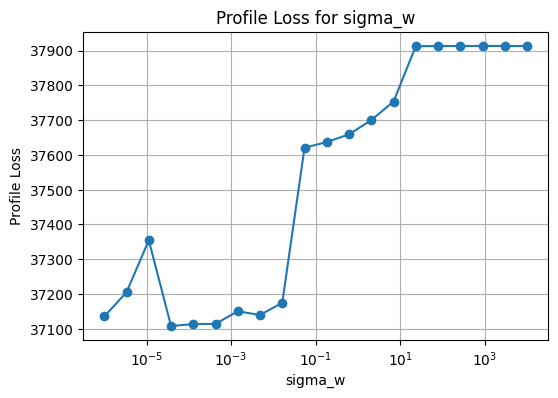

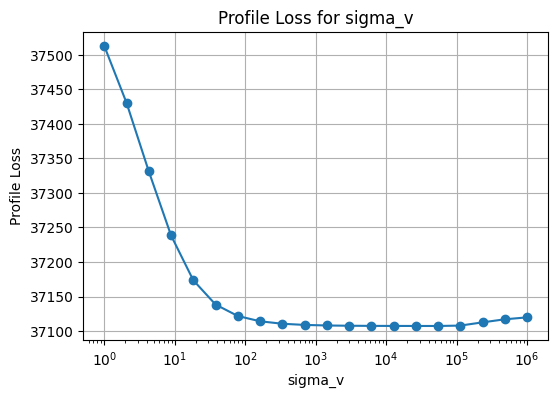

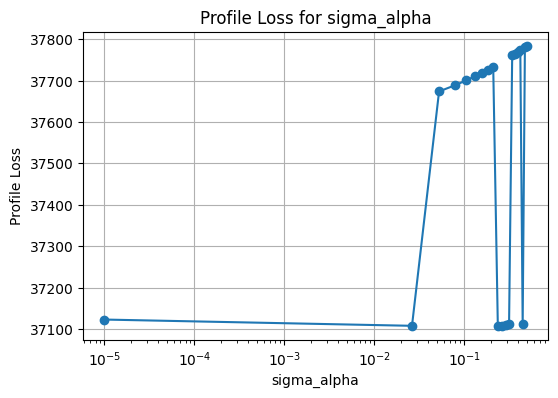

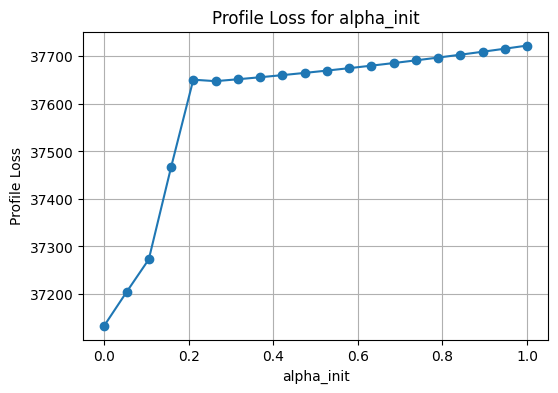

Likelihood loss


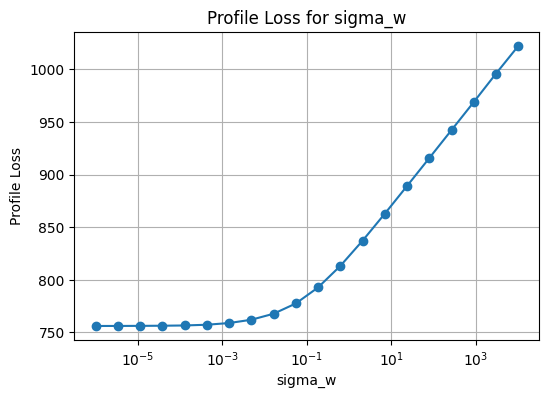

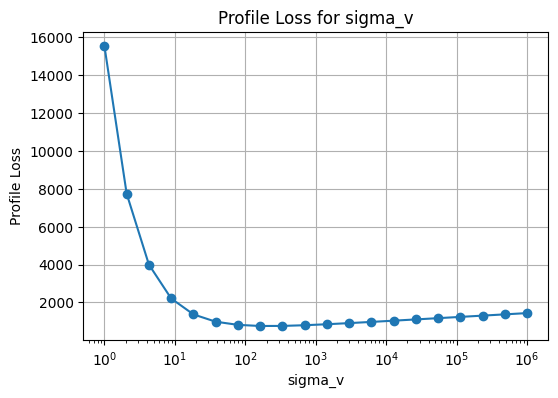

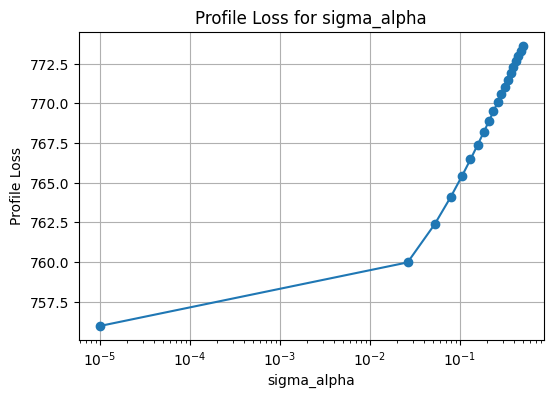

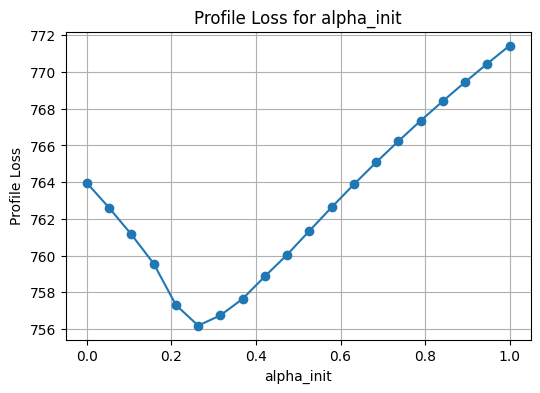

In [12]:
# PROFILE LOSS FOR EACH PARAM

def profile_params(obj_func, x0, bounds, param_names):
    grids = {
        'sigma_w': np.logspace(-6, 4, 20),
        'sigma_v': np.logspace(0, 6, 20),
        'sigma_alpha': np.linspace(1e-5, 0.5, 20),
        'alpha_init': np.linspace(0, 1, 20)
    }

    def profile_param(param_name, param_grid):
        idx = param_names.index(param_name)
        losses = []

        for val in param_grid:
            def constrained_obj(var_params):
                full_params = list(var_params)
                full_params.insert(idx, val)
                return obj_func(full_params)

            # optimise other parameters
            x0_var = [p for i, p in enumerate(x0) if i != idx]
            bounds_var = [b for i, b in enumerate(bounds) if i != idx]
            res = minimize(constrained_obj, x0_var, bounds=bounds_var)
            losses.append(res.fun)

        return param_grid, losses

    # loop over all params
    for name in param_names:
        grid = grids[name]
        grid_vals, losses = profile_param(name, grid)

        # plot inline
        plt.figure(figsize=(6, 4))
        if 'sigma' in name:
            plt.semilogx(grid_vals, losses, marker='o')
        else:
            plt.plot(grid_vals, losses, marker='o')

        plt.xlabel(name)
        plt.ylabel('Profile Loss')
        plt.title(f'Profile Loss for {name}')
        plt.grid(True)
        plt.show()

param_names = ['sigma_w', 'sigma_v', 'sigma_alpha', 'alpha_init']
x0 = [0.1, 40, 0.3, 0.25]
bounds = [(1e-6, 1e4), (1, 1e6), (1e-5, 0.5), (0, 1)]

# plot
print('Combined loss')
profile_params(obj_combined, x0, bounds, param_names)
print('Likelihood loss')
profile_params(obj_ll, x0, bounds, param_names)






In [13]:
# NEW METRIC FUNCTIONS:

# - STD ASYCHRONIES & LAG-1 AUTOCORRELATION
# - ASYNCHRONY TIMESERIES
# - HEATMAP; STD ASYNC & LAG-1 (sigma_v, sigma_w)
# - PARETO CURVE; MSE_S VS MSE_ASYNC
# - HESSIAN EIGENVALUE SPECTRUM

# std async & lag-1 autocorr
def sync_metrics(A_true, r_est):
    metrics = {}
    pairs = A_true.keys()
    for pair in pairs:
        true_A = A_true[pair]
        pred_A = r_est[pair[0]] - r_est[pair[1]]
        mask = ~np.isnan(true_A) & ~np.isnan(pred_A)

        true_asyncs = true_A[mask] # true asynchronies
        pred_asyncs = pred_A[mask] # predicted asynchronies

        if len(true_asyncs) > 1:
            true_std = np.std(true_asyncs)
            true_lag_1 = np.corrcoef(true_asyncs[:-1], true_asyncs[1:])[0, 1]
        else:
            true_std, true_lag_1 = np.nan, np.nan

        if len(pred_asyncs) > 1:
            pred_std = np.std(pred_asyncs)
            pred_lag_1 = np.corrcoef(pred_asyncs[:-1], pred_asyncs[1:])[0, 1]
        else:
            pred_std, pred_lag_1 = np.nan, np.nan

        metrics[pair] = {
            'true_std': true_std,
            'true_lag_1': true_lag_1,
            'pred_std': pred_std,
            'pred_lag_1': pred_lag_1
        }


    return metrics

# bar plot; std asyncs & lag-1 autocorr, pairwise
def plot_async_metrics(metrics):
    pairs = list(metrics.keys())
    true_stds = [metrics[p]['true_std'] for p in pairs]
    pred_stds = [metrics[p]['pred_std'] for p in pairs]
    true_lag_1s = [metrics[p]['true_lag_1'] for p in pairs]
    pred_lag_1s = [metrics[p]['pred_lag_1'] for p in pairs]



    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # standard deviation plot
    width = 0.35
    x = np.arange(len(pairs))
    ax[0].bar(x - width/2, true_stds, width, label="True", color='skyblue')
    ax[0].bar(x + width/2, pred_stds, width, label="Pred", color='orange')
    ax[0].set_title("Std of Asynchronies")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(pairs, rotation=45)
    ax[0].legend()

    # lag-1 autocorr plot
    ax[1].bar(x - width/2, true_lag_1s, width, label="True", color='salmon')
    ax[1].bar(x + width/2, pred_lag_1s, width, label="Pred", color='green')
    ax[1].set_title("Lag-1 Autocorr of Asynchronies")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(pairs, rotation=45)
    ax[1].legend()

    # plt.tight_layout()
    # plt.show()

# helpful fcts
def lag1_ac(x):
   # lag-1 autocorr ignoring nans
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    return np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else np.nan

def compute_std_and_lag1(A_true, r_est):
    # compute mean std and lag-1 autocorr of async errors
    stds, lags = [], []
    for pair in A_true:
        pred = r_est[pair[0]] - r_est[pair[1]]
        true = A_true[pair]
        mask = ~np.isnan(pred) & ~np.isnan(true)
        if mask.sum() > 1:
            resid = true[mask] - pred[mask]
            stds.append(np.std(resid))
            lags.append(lag1_ac(resid))
    return np.mean(stds), np.mean(lags)

def run_model(params, r_data, s_data, A, w):
    # run KF with params dict, return r_est only
    s_hat, _, _ = KF_ensemble(
        s=s_data,
        A=A,
        Sigma_v_init=np.diag([params['sigma_v']] * len(s_data)),
        Sigma_w=params['sigma_w'],
        alpha_KF_init=[params['alpha_init']] * (len(s_data)*(len(s_data)-1)),
        Sigma_alpha_init=np.diag([params['sigma_alpha']] * (len(s_data)*(len(s_data)-1))),
        w=w
    )
    r_est = r_from_s_ensemble(s_hat, r_data, w)
    return r_est


# plot async timeseries comparison
def plot_async_timeseries(pair, A_true, r_old, r_new, title=""):
    t = np.arange(len(A_true[pair]))
    A_old = r_old[pair[0]] - r_old[pair[1]]
    A_new = r_new[pair[0]] - r_new[pair[1]]
    plt.figure(figsize=(12,4))
    plt.plot(t, A_true[pair], label='True', lw=2)
    plt.plot(t, A_old, label='Old (init)', alpha=0.7)
    plt.plot(t, A_new, label='Optimised', alpha=0.7)
    plt.xlabel("Time step"); plt.ylabel("Asynchrony (ms)")
    plt.title(f"Asynchrony timeseries {pair} {title}")
    plt.legend(); plt.grid(True); plt.show()


# heatmap std vs lag-1
def heatmap_std_lag1(sigma_w_vals, sigma_v_vals, params, r_data, s_data, A, w):
    std_map = np.zeros((len(sigma_v_vals), len(sigma_w_vals)))
    lag_map = np.zeros_like(std_map)

    for i, sv in enumerate(sigma_v_vals):
        for j, sw in enumerate(sigma_w_vals):
            params_mod = params.copy()
            params_mod['sigma_v'] = sv
            params_mod['sigma_w'] = sw
            r_est = run_model(params_mod, r_data, s_data, A, w)
            std_val, lag_val = compute_std_and_lag1(A, r_est)
            std_map[i,j] = std_val; lag_map[i,j] = lag_val

    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    im1 = ax[0].imshow(std_map, origin='lower', aspect='auto',
                       extent=[sigma_w_vals[0], sigma_w_vals[-1],
                               sigma_v_vals[0], sigma_v_vals[-1]])
    ax[0].set_xscale('log'); ax[0].set_yscale('log')
    ax[0].set_title("Std of async"); ax[0].set_xlabel("sigma_w"); ax[0].set_ylabel("sigma_v")
    plt.colorbar(im1, ax=ax[0])

    im2 = ax[1].imshow(lag_map, origin='lower', aspect='auto',
                       extent=[sigma_w_vals[0], sigma_w_vals[-1],
                               sigma_v_vals[0], sigma_v_vals[-1]])
    ax[1].set_xscale('log'); ax[1].set_yscale('log')
    ax[1].set_title("Lag-1 autocorr"); ax[1].set_xlabel("sigma_w"); ax[1].set_ylabel("sigma_v")
    plt.colorbar(im2, ax=ax[1])
    plt.tight_layout(); plt.show()

# pareto curve (weighting on each mse)
def pareto_curve(weights, r_data, s_data, A, w, init_guess, bounds):
    losses = []
    for wgt in weights:
        def obj(params):
            pdict = {'sigma_w':params[0],'sigma_v':params[1],
                     'sigma_alpha':params[2],'alpha_init':params[3]}
            return np.mean(list(combined_loss(r_data, s_data, A, w, KF_ensemble, pdict, weight=wgt).values()))
        res = minimize(obj, init_guess, bounds=bounds)
        losses.append(res.fun)
    plt.figure(figsize=(6,4))
    plt.plot(weights, losses, marker='o')
    plt.xscale('log'); plt.xlabel("Weight on async mse")
    plt.ylabel("Combined Loss"); plt.title("Pareto Curve")
    plt.grid(True); plt.show()

# hessian eigenvalue spectrum
# def hessian_spectrum(obj_func, params, eps=1e-5):
#     n = len(params); hess = np.zeros((n, n))
#     for i in range(n):
#         for j in range(n):
#             ei = np.zeros_like(params); ej = np.zeros_like(params)
#             ei[i]=eps; ej[j]=eps
#             fpp = obj_func(params+ei+ej); fpm = obj_func(params+ei-ej)
#             fmp = obj_func(params-ei+ej); fmm = obj_func(params-ei-ej)
#             hess[i,j]=(fpp-fpm-fmp+fmm)/(4*eps**2)
#     eigs = np.sort(np.abs(np.linalg.eigvals(hess)))[::-1]
#     plt.figure(figsize=(6,4))
#     plt.semilogy(eigs, marker='o')
#     plt.title("Hessian eigenvalue spectrum")
#     plt.xlabel("Index"); plt.ylabel("Eigenvalue")
#     plt.grid(True); plt.show()
#     return eigs


Leader: VN1, Repetition: 1, Window Size: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Correlation & Std Improvement for s_pred Timeseries (after optimisation):
  Leader  Repetition  Window Size Condition   Loss Type  Corr Init  Corr Opt  \
0    VN1           1            5        DP    Combined    0.46050   0.46375   
1    VN1           1            5        NR    Combined    0.33075   0.55975   
2    VN1           1            5        SP    Combined    0.50850   0.65950   
3    VN1           1            5        DP  Likelihood    0.46050   0.71575   
4    VN1           1            5        NR  Likelihood    0.33075   0.69325   
5    VN1           1            5        SP  Likelihood    0.50850   0.77800   

   % Corr Improvement  Std Init   Std Opt  % Std Improvement  
0            0.705755  19.79275  17.93625           9.379697  
1           69.236584  25.40300  17.56825          30.841830  
2           29.695182  24.34425  19.02275          21.859371  
3           55.428882  19.79275  14.29575          27.772796  
4          109.599395  25.40300  15.43925        

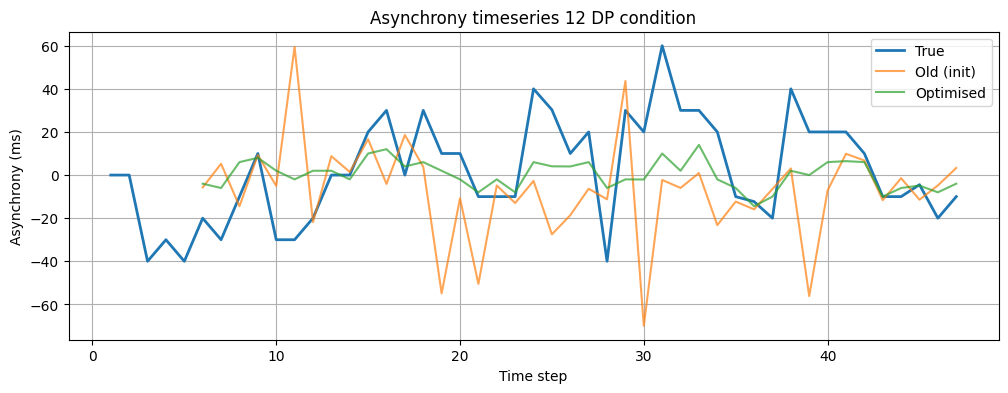

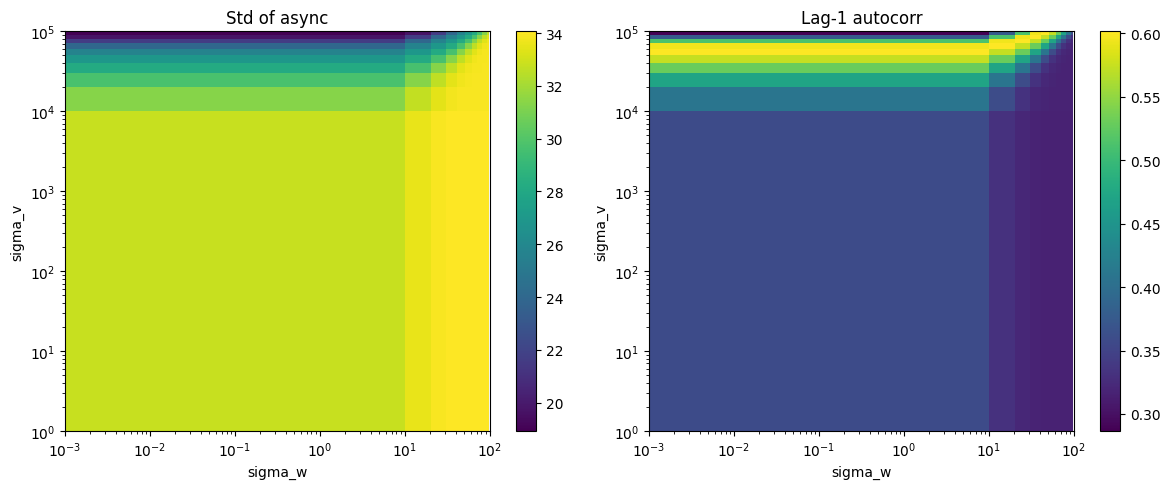

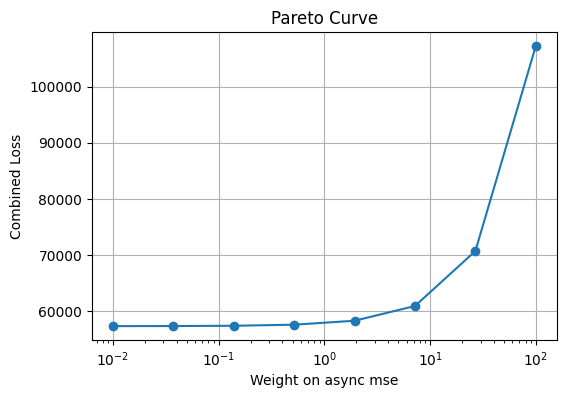

In [14]:
# ANALYSIS OF A SINGLE CASE #

# choose case
leader = 'VN1'
rep = 1
w = 5
weight = 0.1

# get optimised results
params_opt_pred_dp = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'DP')]['sigma_w_comb'].iloc[0], df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'DP')]['sigma_v_comb'].iloc[0]
params_opt_ll_dp = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'DP')]['sigma_w_ll'].iloc[0], df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'DP')]['sigma_v_ll'].iloc[0]

params_opt_pred_nr = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'NR')]['sigma_w_comb'].iloc[0], df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'NR')]['sigma_v_comb'].iloc[0]
params_opt_ll_nr = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'NR')]['sigma_w_ll'].iloc[0], df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'NR')]['sigma_v_ll'].iloc[0]

params_opt_pred_sp = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'SP')]['sigma_w_comb'].iloc[0], df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'SP')]['sigma_v_comb'].iloc[0]
params_opt_ll_sp = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'SP')]['sigma_w_ll'].iloc[0], df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == 'SP')]['sigma_v_ll'].iloc[0]


# init params
params_init = {'sigma_w': 0.1, 'sigma_v': 40, 'sigma_alpha': 0.3, 'alpha_init': 0.25}

# initialise for case
r_dp, r_nr, r_sp, s_dp_win, s_nr_win, s_sp_win, A_dp, A_nr, A_sp, _, _, _ = process_ensemble_data(leader=leader, rep=rep, w=w)

conditions_data = {
    'DP': {'r_data': r_dp, 's_data': s_dp_win, 'A': A_dp, 'opt_combined': {'sigma_w': params_opt_pred_dp[0], 'sigma_v': params_opt_pred_dp[1]}, 'opt_ll': {'sigma_w': params_opt_ll_dp[0], 'sigma_v': params_opt_ll_dp[1]}},
    'NR': {'r_data': r_nr, 's_data': s_nr_win, 'A': A_nr, 'opt_combined': {'sigma_w': params_opt_pred_nr[0], 'sigma_v': params_opt_pred_nr[1]}, 'opt_ll': {'sigma_w': params_opt_ll_nr[0], 'sigma_v': params_opt_ll_nr[1]}},
    'SP': {'r_data': r_sp, 's_data': s_sp_win, 'A': A_sp, 'opt_combined': {'sigma_w': params_opt_pred_sp[0], 'sigma_v': params_opt_pred_sp[1]}, 'opt_ll': {'sigma_w': params_opt_ll_sp[0], 'sigma_v': params_opt_ll_sp[1]}}
}

loss_types = ['Combined', 'Likelihood']
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

print(f"Leader: {leader}, Repetition: {rep}, Window Size: {w}")


# EXPT 1: compare r reconstructed with r true and calc % improvement in correlation (og vs opt cases)
# EXPT 2: std of asynchronies for each pair, lag-1 autocorr of asynchronies for that pair
metrics_comparison_results = []
for loss_name, loss_func in zip(loss_types, [combined_loss, likelihood_loss]):
    for cond, data in conditions_data.items():
        r_data, s_data, A = data['r_data'], data['s_data'], data['A']

        if loss_name == 'Combined':
            params_opt = data['opt_combined']
            opt_alpha = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == cond)]['sigma_alpha_comb'].iloc[0]
            opt_alpha_init = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == cond)]['alpha_init_comb'].iloc[0]
        else:
            params_opt = data['opt_ll']
            opt_alpha = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == cond)]['sigma_alpha_ll'].iloc[0]
            opt_alpha_init = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == cond)]['alpha_init_ll'].iloc[0]

        # unoptimised case
        s_hat_init, _, _ = KF_ensemble(
            s=s_data,
            A=A,
            Sigma_v_init=np.diag([params_init['sigma_v']] * len(s_data)),
            Sigma_w=params_init['sigma_w'],
            alpha_KF_init=[params_init['alpha_init']] * (len(s_data) * (len(s_data) - 1)),
            Sigma_alpha_init=np.diag([params_init['sigma_alpha']] * (len(s_data) * (len(s_data) - 1))),
            w=w
        )
        r_hat_init = r_from_s_ensemble(s_hat_init, r_data, w=w)
        metrics_init = metrics_ensemble(r_hat_init, r_data)

        # optimised case
        s_hat_opt, _, _ = KF_ensemble(
            s=s_data,
            A=A,
            Sigma_v_init=np.diag([params_opt['sigma_v']] * len(s_data)),
            Sigma_w=params_opt['sigma_w'],
            alpha_KF_init=[opt_alpha_init] * (len(s_data) * (len(s_data) - 1)),
            Sigma_alpha_init=np.diag([opt_alpha] * (len(s_data) * (len(s_data) - 1))),
            w=w
        )
        r_hat_opt = r_from_s_ensemble(s_hat_opt, r_data, w=w)
        metrics_opt = metrics_ensemble(r_hat_opt, r_data)

        # mean across players
        corr_init_mean = np.nanmean([m['corr'] for m in metrics_init.values()])
        corr_opt_mean = np.nanmean([m['corr'] for m in metrics_opt.values()])
        std_init_mean = np.nanmean([m['std'] for m in metrics_init.values()])
        std_opt_mean = np.nanmean([m['std'] for m in metrics_opt.values()])

        corr_improvement = ((corr_opt_mean - corr_init_mean) / abs(corr_init_mean)) * 100 if corr_init_mean != 0 else 0
        std_improvement = ((std_init_mean - std_opt_mean) / abs(std_init_mean)) * 100 if std_init_mean != 0 else 0

        metrics_comparison_results.append({
            'Leader': leader,
            'Repetition': rep,
            'Window Size': w,
            'Condition': cond,
            'Loss Type': loss_name,
            'Corr Init': corr_init_mean,
            'Corr Opt': corr_opt_mean,
            '% Corr Improvement': corr_improvement,
            'Std Init': std_init_mean,
            'Std Opt': std_opt_mean,
            '% Std Improvement': std_improvement
        })

        # std asynchronies & lag-1 autocorr bar plots
        # new_mets = sync_metrics(A, r_hat_init)
        # print('Condition:', cond, 'Loss Type:', loss_name, 'Original')
        # plot_async_metrics(new_mets)

        # new_mets = sync_metrics(A, r_hat_opt)
        # print('Condition:', cond, 'Loss Type:', loss_name, 'Optimised')
        # plot_async_metrics(new_mets)


# save as metrics comparison
df_metrics_comparison = pd.DataFrame(metrics_comparison_results)
df_metrics_comparison.to_csv('metrics_comparison.csv', index=False)
files.download('metrics_comparison.csv')

# display
print("\nCorrelation & Std Improvement for s_pred Timeseries (after optimisation):")
print(df_metrics_comparison)

# EXPT 3: compare losses and calculate % improvement for each loss type
# loss_comparison_results = []
# for i, (loss_name, loss_func) in enumerate(zip(loss_types, [combined_loss, likelihood_loss])):
#     for j, (cond, data) in enumerate(conditions_data.items()):
#         r_data, s_data, A = data['r_data'], data['s_data'], data['A']

#         # get opt params for condition and loss type
#         if loss_name == 'Combined':
#             params_opt = data['opt_combined']
#         else:
#             params_opt = data['opt_ll']

#         # losses
#         loss_init_dict = loss_func(r_data, s_data, A, w, KF_ensemble, params_init)
#         loss_opt_dict = loss_func(r_data, s_data, A, w, KF_ensemble, params_opt)

#         loss_init_mean = np.mean(list(loss_init_dict.values()))
#         loss_opt_mean = np.mean(list(loss_opt_dict.values()))

#         # % improvement
#         if loss_init_mean != 0:
#             improvement = ((loss_init_mean - loss_opt_mean) / loss_init_mean) * 100
#         else:
#             improvement = 0

#         loss_comparison_results.append({
#             'Leader': leader,
#             'Repetition': rep,
#             'Window Size': w,
#             'Condition': cond,
#             'Loss Type': loss_name,
#             'Initial Loss': loss_init_mean,
#             'Optimised Loss': loss_opt_mean,
#             '% Improvement': improvement
#         })

# save as loss comparison
# df_loss_comparison = pd.DataFrame(loss_comparison_results)
# df_loss_comparison.to_csv('loss_comparison_results.csv', index=False)
# files.download('loss_comparison_results.csv')

# # display
# print("Improvement in Loss (after optimisation):")
# print(df_loss_comparison)

# NEW EXPTS - maybe reformulate prev expts using simplified fcts...

# choose dataset
data = conditions_data['DP'] # loop through all conditions later? (DP for now)
r_data, s_data, A = data['r_data'], data['s_data'], data['A']

# param dicts
opt_alpha = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == cond)]['sigma_alpha_comb'].iloc[0]
opt_alpha_init = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == cond)]['alpha_init_comb'].iloc[0]
params_opt = {'sigma_w': data['opt_combined']['sigma_w'],
              'sigma_v': data['opt_combined']['sigma_v'],
              'sigma_alpha': opt_alpha, 'alpha_init': opt_alpha_init}

# run KF for init/opt
r_init = run_model(params_init, r_data, s_data, A, w)
r_opt  = run_model(params_opt,  r_data, s_data, A, w)

# EXPT 4: asynchrony timeseries comparison
plot_async_timeseries('12', A, r_init, r_opt, title="DP condition")

# EXPT 5: heatmap; async std vs lag-1 autocorr
sigma_w_vals = np.logspace(-3, 2, 10)
sigma_v_vals = np.logspace(0, 5, 10)
heatmap_std_lag1(sigma_w_vals, sigma_v_vals, params_opt, r_data, s_data, A, w)

# EXPT 6: pareto curve
weights = np.logspace(-2, 2, 8)
init_guess = [0.1, 40, 0.3, 0.25]
pareto_curve(weights, r_data, s_data, A, w, init_guess, bounds)

# EXPT 7: hessian spectrum
# def obj(params):
#     pdict = {'sigma_w':params[0],'sigma_v':params[1],'sigma_alpha':params[2],'alpha_init':params[3]}
#     return np.mean(list(combined_loss(r_data, s_data, A, w, KF_ensemble, pdict, weight=100).values()))
# params_vec = np.array([params_opt['sigma_w'], params_opt['sigma_v'], params_opt['sigma_alpha'], params_opt['alpha_init']])
# eigs = hessian_spectrum(obj, params_vec)






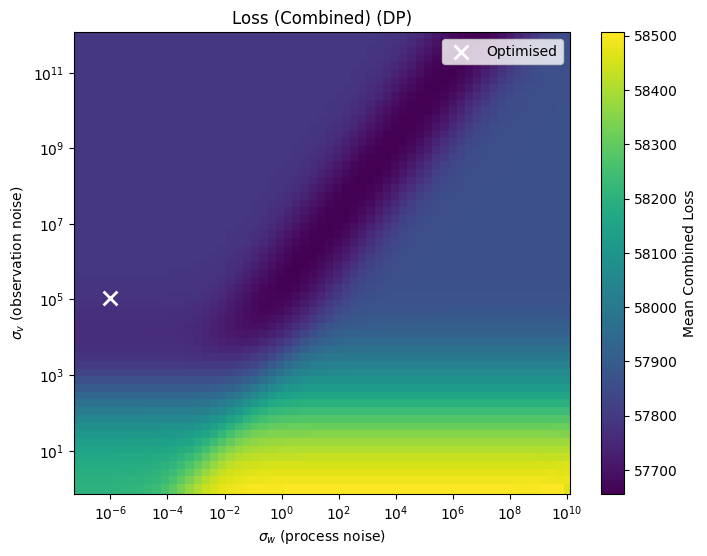

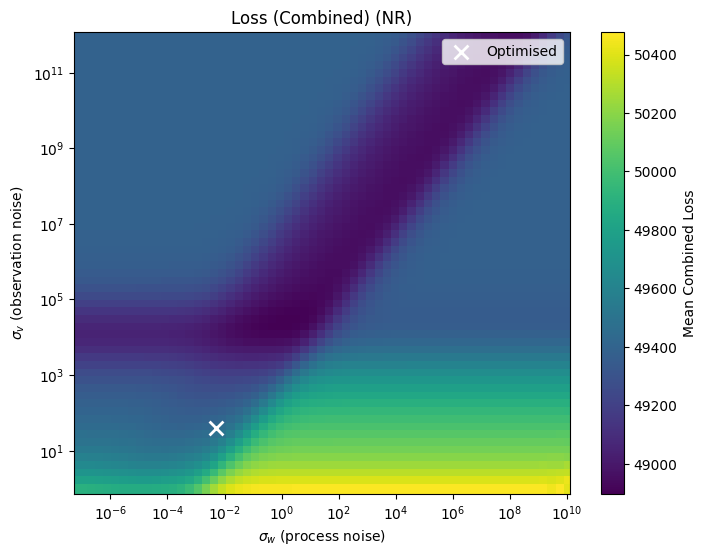

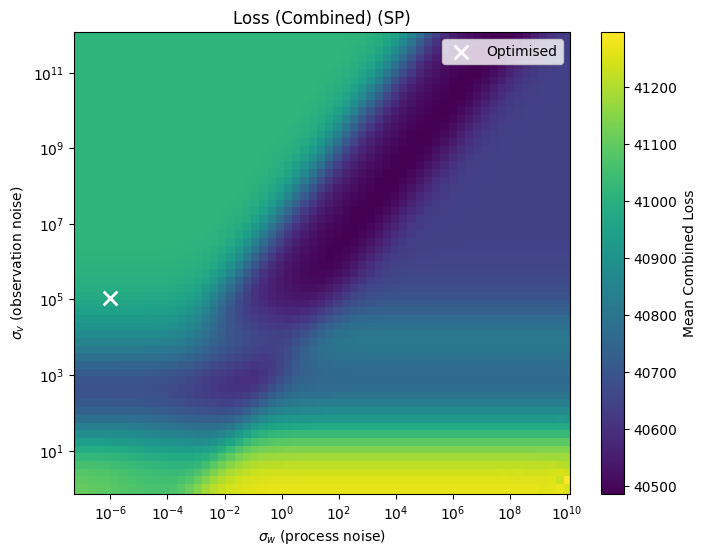

In [15]:
# HEATMAP
# loop through conditions
conds = ['DP', 'NR', 'SP']
for cond in conds:
    r_data = conditions_data[cond]['r_data']
    s_data = conditions_data[cond]['s_data']
    A = conditions_data[cond]['A']

    # param ranges
    sigma_v_values = np.logspace(0, 12, 60)
    sigma_w_values = np.logspace(-7, 10, 60)
    sigma_alpha_values = np.linspace(1e-4, 1e-3, 60)
    alpha_init_values = np.linspace(0, 0.6, 60)

    # loss grid (s_v, s_w)
    loss_grid = np.full((len(sigma_v_values), len(sigma_w_values)), np.nan)

    for i, sigma_v in enumerate(sigma_v_values):
        for j, sigma_w in enumerate(sigma_w_values):
            params_test = {
                'sigma_v': sigma_v,
                'sigma_w': sigma_w,
                'sigma_alpha': 0.3, # fixed
                'alpha_init': 0.25 # fixed
            }
            try:
                loss_dict = combined_loss(r_data, s_data, A, w, KF_ensemble, params_test, weight=weight)
                loss_grid[i, j] = np.nanmean(list(loss_dict.values()))
            except np.linalg.LinAlgError:
                pass  # leave nan for unstable combos

    # plot s_v, s_w heatmap
    S_W, S_V = np.meshgrid(sigma_w_values, sigma_v_values)
    fig, ax = plt.subplots(figsize=(8, 6))
    h = ax.pcolormesh(S_W, S_V, loss_grid, shading='auto', cmap='viridis')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\sigma_w$ (process noise)')
    ax.set_ylabel(r'$\sigma_v$ (observation noise)')
    ax.set_title(f'Loss (Combined) ({cond})')

    cbar = plt.colorbar(h, ax=ax)
    cbar.set_label('Mean Combined Loss')

    # mark optimised point
    opt = conditions_data[cond]['opt_combined']
    ax.scatter(opt['sigma_w'], opt['sigma_v'], marker='x', s=100, color='white', linewidths=2, label='Optimised')
    ax.legend()

    plt.show()

# loss grid (s_alpha, alpha_init)
loss_grid = np.full((len(sigma_alpha_values), len(alpha_init_values)), np.nan)
s_v_fixed = 1e4
s_w_fixed = 1e-1
for i, s_alpha in enumerate(sigma_alpha_values):
    for j, alpha_init in enumerate(alpha_init_values):
        params_test = {
            'sigma_v': s_v_fixed, # fixed
            'sigma_w': s_w_fixed, # fixed
            'sigma_alpha': s_alpha,
            'alpha_init': alpha_init
        }
        try:
            loss_dict = combined_loss(r_data, s_data, A, w, KF_ensemble, params_test)
            loss_grid[i, j] = np.nanmean(list(loss_dict.values()))
        except np.linalg.LinAlgError:
            pass  # leave nan for unstable combos

# # plot s_alpha, alpha_init heatmap
# S_A, A_I = np.meshgrid(sigma_alpha_values, alpha_init_values)
# fig, ax = plt.subplots(figsize=(8, 6))
# h = ax.pcolormesh(S_A, A_I, loss_grid.T, shading='auto', cmap='viridis')

# # ax.set_xscale('log')
# ax.set_xlabel(r'$\sigma_{\alpha}$ (Initial Alpha Uncertainty)')
# ax.set_ylabel(r'$\alpha_{init}$ (Initial Alpha Value)')
# ax.set_title(f'Loss (Combined) Heatmap')

# cbar = plt.colorbar(h, ax=ax)
# cbar.set_label('Mean Combined Loss')

# # obtain optimised results
# opt_alpha = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == cond)]['sigma_alpha_pred'].iloc[0]
# opt_alpha_init = df_results[(df_results['leader'] == leader) & (df_results['repetition'] == rep) & (df_results['window_size'] == w) & (df_results['condition'] == cond)]['alpha_init_pred'].iloc[0]

# # mark optimised point
# ax.scatter(opt_alpha, opt_alpha_init, marker='x', s=100, color='white', linewidths=2, label='Optimised')
# ax.legend()

# # plt.show()